In [1]:
# Make sure we have the packages we need
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
plt.style.use('ggplot')

np.random.seed(123456789)

## Cox, Russ, and Rubinstein Binomial Tree Method

### Model Inputs

In [2]:
# set up parameters
S_0 = 10 # initial XYZ stock price
k = 10 # strike price of the XYZ option
r = 0.02 # riskfree interest rate
sigma = 0.7 # volatility or "randomness"
div = 0.0 # dividend yield
T = 1 # XYZ option maturity date in 1 year
dt = 1/244 # time difference factor (244 trading days per annum)
time = np.arange(dt,T+dt,dt) # time points
N = len(time) # number of time intervals

### Binomial Lattice Stock Tree

In [3]:
def binomial_stock_price_tree(N, S_0, r, sigma, dt, div):
    '''
    Generate the underlying XYZ stock price in "tree form" by using Binomial Tree model with up move rate "u" and 
    down move rate "d"

    Args:
        N: number of time intervals until maturity
        S_0: initial XYZ stock price
        r: (annualized continuously compounded) riskfree interest rate
        sigma: (annualized) volatility (standard deviation)
        dt: time difference factor
        div: continuous dividend yield

    Return:
        binomial_tree_stock_price: the matrix of the underlying stock price in "tree" form (in numpy.array)
        q: the risk-neutral probability of an up move
    
    '''
    
    # generate binomial tree model inputs
    u = np.exp(sigma*np.sqrt(dt)) # up move rate
    d = np.exp(-sigma*np.sqrt(dt)) # down move rate
    q = (np.exp((r-div)*dt)-d)/(u-d) # risk-neutral probability of an up move
    
    # generate binomial tree model
    binomial_tree_stock_price = np.zeros([N+1,N+1])
    for i in range(binomial_tree_stock_price.shape[1]):
        for j in range(i+1):
            binomial_tree_stock_price[j,i] = S_0*(u**(i-j))*(d**(j))         
                 
    return binomial_tree_stock_price, q

In [4]:
S, q = binomial_stock_price_tree(N, S_0, r, sigma, dt,div)

In [5]:
pd.DataFrame(S) # print binomial stock price tree

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,10.00,10.46,10.94,11.44,11.96,12.51,13.08,13.68,14.31,14.97,...,374601.65,391770.46,409726.15,428504.79,448144.09,468683.51,490164.30,512629.59,536124.52,560696.28
1,0.00,9.56,10.00,10.46,10.94,11.44,11.96,12.51,13.08,13.68,...,342488.26,358185.24,374601.65,391770.46,409726.15,428504.79,448144.09,468683.51,490164.30,512629.59
2,0.00,0.00,9.14,9.56,10.00,10.46,10.94,11.44,11.96,12.51,...,313127.84,327479.17,342488.26,358185.24,374601.65,391770.46,409726.15,428504.79,448144.09,468683.51
3,0.00,0.00,0.00,8.74,9.14,9.56,10.00,10.46,10.94,11.44,...,286284.41,299405.44,313127.84,327479.17,342488.26,358185.24,374601.65,391770.46,409726.15,428504.79
4,0.00,0.00,0.00,0.00,8.36,8.74,9.14,9.56,10.00,10.46,...,261742.17,273738.38,286284.41,299405.44,313127.84,327479.17,342488.26,358185.24,374601.65,391770.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
241,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
242,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
243,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Cox Ross Rubinstein Binomial Model (1979) for American Options Pricing

In [6]:
def Cox_Russ_Rubinstein_american_options(N, S_0, r, sigma, dt, div, k, optionType="c", showTree=1):
    '''
    The binomial approach is a discrete valuation model for European/American options on derivative securities, it 
    was first suggested by William Sharpe in 1978. However, this methodology is normally associated with the paper 
    by John Cox, Stephen Ross, and Mark Rubinstein in 1979. The binomial approach also known as lattice approach 
    can be used to value wide-range of general derivative securities and also to obtain exact formula by taking the
    limit in which the binomial tree converges to a continuum.

    As proposed by Cox, Ross, Rubinstein, this method divides the time until option maturity into discrete intervals 
    and presumes that, during each of these intervals, the price of the asset — e.g., the stock — follows a binomial
    process moving from its initial value, S, to Su (with probability p) or Sd (with probability 1-p). Given this 
    set of share prices, the call/put can be valued by working backwards from maturity. The power of the binomial 
    model is that it can value wide-range of derivative securities. For example, we can use the two binomial tree 
    to price a Two-Assets option.

    Args:
        N: number of time intervals until maturity
        S_0: initial XYZ stock price
        r: (annualized) continuous riskfree interest rate
        sigma: (annualized) volatility (standard deviation)
        dt: time difference factor
        div: (annualized) continuous dividend yield
        k: XYZ option strike price
        optionType: if input is "c", solving for American call option; if input is "p", solving for American put option
        showTree: if true, print the stock price tree and immediate exercise flag tree
        
        
    Return:
        value: the value (cash flow) matrix of the American options given in each discretized time point 
        (in numpy.array)
    
    '''
    
    # generate binomial tree model inputs
    u = np.exp(sigma*np.sqrt(dt)) # up move rate
    d = np.exp(-sigma*np.sqrt(dt)) # down move rate
    q = (np.exp((r-div)*dt)-d)/(u-d) # risk-neutral probability of an up move
    
    stock_price_tree = np.zeros([N+1,N+1]) # generated stock price under Binomial Tree model
    immediate_exercise_tree = np.zeros([N+1,N+1], dtype=bool) # generate immediate exercise flag tree
    value = np.zeros([N+1,N+1]) # final optimal American option cash flow matrix
    
    for i in range(N,-1,-1): # do in backwardation
        
        if optionType == "c":
            
            S_current = S_0 * d**np.arange(0,i+1,1) * u**np.arange(i,-1,-1) # generate current stock price under Binomial Tree for American call option

        elif optionType == "p":
        
            S_current = S_0 * u**np.arange(0,i+1,1) * d**np.arange(i,-1,-1) # generate current stock price under Binomial Tree for American put opion

        stock_price_tree[:i+1,i] = S_current
        
        if i == N: # determine if exercise the option at maturity at each node
            
            if optionType == "c":
                
                value[:,i] = (S_current - k)*(S_current > k) # store the option payoff if greater than 0 at maturity node for American call option
            
            elif optionType == "p":
                
                value[:,i] = (k - S_current)*(k > S_current) # store the option payoff if greater than 0 at maturity node for American put option

            immediate_exercise_tree[:,i] = (k > S_current)
            
        elif i == 0: # determine the risk-neutral discounted expectation value at inception
            
            if optionType == "c":
            
                value[:i+1,i] = np.exp(-r*dt)*(q*value[:i+1,i+1] + (1-q)*value[1:i+2,i+1]) # calculate the risk-neutral discounted expectation value at initial node for American call option
            
            if optionType == "p":
            
                value[:i+1,i] = np.exp(-r*dt)*((1-q)*value[:i+1,i+1] + q*value[1:i+2,i+1]) # calculate the risk-neutral discounted expectation value at initial node for American put option
            
        else: # do backwardation until the inception
            
            if optionType == "c":

                discounted_continuation_value = np.exp(-r*dt)*(q*value[:i+1,i+1] + (1-q)*value[1:i+2,i+1]) # calculate the risk-neutral discounted expectation value from the previous node for American call option

                immediate_exercise_value = (S_current - k)*(S_current > k) # immediately exercise value at current intermediate node for American call option
            
            elif optionType == "p":
                
                discounted_continuation_value = np.exp(-r*dt)*((1-q)*value[:i+1,i+1] + q*value[1:i+2,i+1]) # calculate the risk-neutral discounted expectation value from the previous node for American put option
            
                immediate_exercise_value = (k - S_current)*(k > S_current) # immediately exercise value at current intermediate node for American put option
            
            optimal_early_exercise_loc = (immediate_exercise_value > discounted_continuation_value).nonzero() # optimal Binomial Tree nodes at which we should early exercise
            
            optimal_early_exercise_cash_flow = immediate_exercise_value[optimal_early_exercise_loc] # optimal early exercise cash flow at current intermediate node
        
            immediate_exercise_tree[optimal_early_exercise_loc,i] = True
            
            value[:i+1,i] = discounted_continuation_value # if do not early exercise the call option, the value of current path will just be the discounted continuation value
            
            value[optimal_early_exercise_loc,i] = optimal_early_exercise_cash_flow # update the current optimal early exercise nodes' value
        
              
    if showTree: # print stock price tree and immediate exercise tree
        print('Stock price tree: ')
        display(pd.DataFrame(stock_price_tree))
        print('Immediate exercise node: ')
        display(pd.DataFrame(immediate_exercise_tree))
                 
    return value

In [7]:
value = Cox_Russ_Rubinstein_american_options(N, S_0, r, sigma, dt, div, k, optionType = "p", showTree=1)
pd.DataFrame(value) # cash flow matrix of the American put option across time

Stock price tree: 


,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,10.00,9.56,9.14,8.74,8.36,7.99,7.64,7.31,6.99,6.68,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,10.46,10.00,9.56,9.14,8.74,8.36,7.99,7.64,7.31,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,10.94,10.46,10.00,9.56,9.14,8.74,8.36,7.99,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,11.44,10.94,10.46,10.00,9.56,9.14,8.74,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,11.96,11.44,10.94,10.46,10.00,9.56,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,468683.51,448144.09,428504.79,409726.15,391770.46
241,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,490164.30,468683.51,448144.09,428504.79
242,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,512629.59,490164.30,468683.51
243,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,536124.52,512629.59


Immediate exercise node: 


,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
1,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
2,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
3,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
4,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
241,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
242,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
243,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,2.63,2.79,2.95,3.11,3.28,3.45,3.62,3.79,3.96,4.14,...,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00
1,0.00,2.47,2.62,2.78,2.94,3.10,3.27,3.44,3.61,3.78,...,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00
2,0.00,0.00,2.31,2.46,2.61,2.77,2.93,3.09,3.26,3.43,...,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00
3,0.00,0.00,0.00,2.15,2.30,2.45,2.60,2.76,2.92,3.08,...,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00
4,0.00,0.00,0.00,0.00,2.00,2.14,2.29,2.43,2.59,2.75,...,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00
241,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00
242,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00
243,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00


In [8]:
value[0,0] # the American put option price estimated by Cox Ross Rubinstein Binomial Model (1979)

2.628356387606265

### American Put Option --- Performance Comparison: Cox Ross Rubinstein Binomial Model (1979) v.s. Least Square Monte Carlo Approach (2001)

In [9]:
from Least_Square_Monte_Carlo import least_square_monte_carlo

#### Testing for Option Moneyness

In [10]:
# set up parameters
reps = 10000 # number of simulations
T = 5 # American option maturity date (in annum)
dt = 1/244 # time difference factor (244 trading days per annum)
time = np.arange(dt,T+dt,dt) # time points
N = len(time) # number of time intervals
r = 0.06 # riskfree interest rate
sigma = 0.7 # volatility or "randomness"
d = 0.0 # dividend yield
S_0 = 100 # initial stock price
K_list = np.arange(90,111,0.5) # strike price of the American option

In [11]:
CRR_binomial_model_value_moneyness = []
LSM_model_value_moneyness = []

for i in K_list:
    binomial_model_value = Cox_Russ_Rubinstein_american_options(N, S_0, r, sigma, dt, div, i, optionType = "p", showTree=0)[0,0]
    LSM_value = np.mean(least_square_monte_carlo(reps, N, i, r, sigma, dt, S_0, d, optionType="p")[:,0])
    CRR_binomial_model_value_moneyness.append(binomial_model_value)
    LSM_model_value_moneyness.append(LSM_value)
   

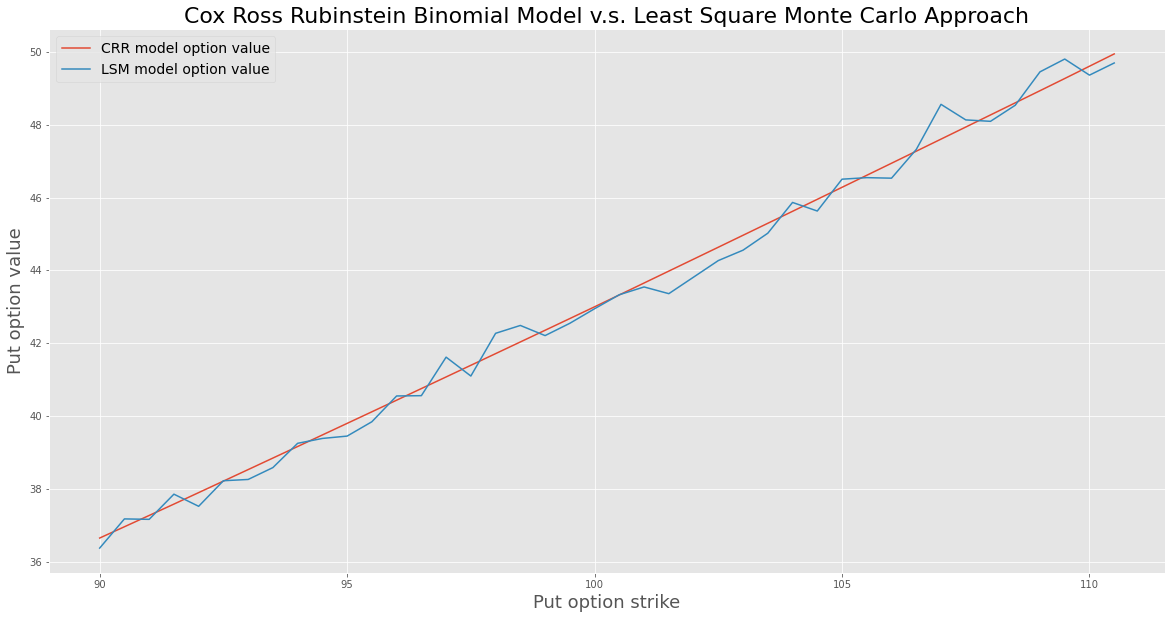

In [12]:
# comparison plot
plt.plot(K_list, CRR_binomial_model_value_moneyness)
plt.plot(K_list, LSM_model_value_moneyness)
plt.xlabel('Put option strike', fontsize = 18)
plt.ylabel('Put option value', fontsize = 18)
plt.title('Cox Ross Rubinstein Binomial Model v.s. Least Square Monte Carlo Approach', fontsize = 22)
plt.legend(['CRR model option value','LSM model option value'], loc = "upper left", fontsize = 14)

#### Testing for maturity

In [13]:
# set up parameters
reps = 10000 # number of simulations
T_list = np.array(np.arange(1,11,0.5)) # American option maturity date (in annum)
dt = 1/244 # time difference factor (244 trading days per annum)
N_list = (T_list/dt).astype(int) # number of time intervals
r = 0.06 # riskfree interest rate
sigma = 0.7 # volatility or "randomness"
d = 0.0 # dividend yield
S_0 = 100 # initial stock price
k = 100 # strike price of the American put option

In [14]:
CRR_binomial_model_value_maturity = []
LSM_model_value_maturity = []

for i in N_list:
    binomial_model_value = Cox_Russ_Rubinstein_american_options(i, S_0, r, sigma, dt, div, k, optionType = "p", showTree=0)[0,0]
    LSM_value = np.mean(least_square_monte_carlo(reps, i, k, r, sigma, dt, S_0, d, optionType="p")[:,0])
    CRR_binomial_model_value_maturity.append(binomial_model_value)
    LSM_model_value_maturity.append(LSM_value)
   

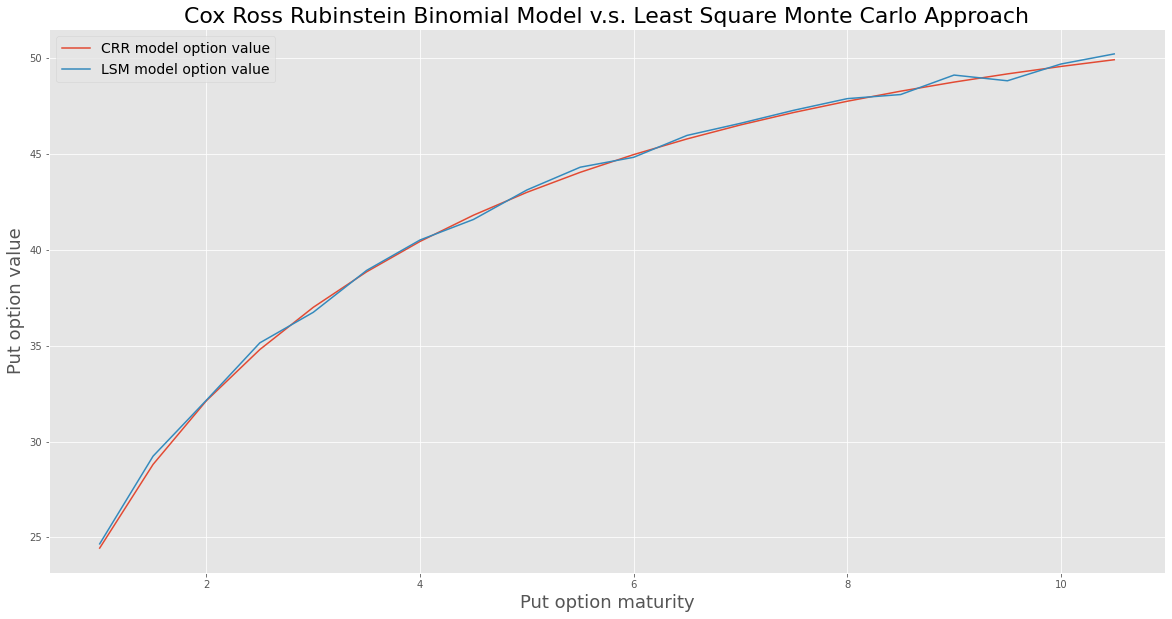

In [15]:
# comparison plot
plt.plot(T_list, CRR_binomial_model_value_maturity)
plt.plot(T_list, LSM_model_value_maturity)
plt.xlabel('Put option maturity', fontsize = 18)
plt.ylabel('Put option value', fontsize = 18)
plt.title('Cox Ross Rubinstein Binomial Model v.s. Least Square Monte Carlo Approach', fontsize = 22)
plt.legend(['CRR model option value','LSM model option value'], loc = "upper left", fontsize = 14)

#### Testing for volatility

In [16]:
# set up parameters
reps = 10000 # number of simulations
T = 5 # American option maturity date (in annum)
dt = 1/244 # time difference factor (244 trading days per annum)
time = np.arange(dt,T+dt,dt) # time points
N = len(time) # number of time intervals
r = 0.06 # riskfree interest rate
sigma_list = np.arange(0.2,1.2,0.05) # volatility or "randomness"
d = 0.0 # dividend yield
S_0 = 100 # initial stock price
k = 100 # strike price of the American put option

In [17]:
CRR_binomial_model_value_volatility = []
LSM_model_value_volatility = []

for i in sigma_list:
    binomial_model_value = Cox_Russ_Rubinstein_american_options(N, S_0, r, i, dt, div, k, optionType = "p", showTree=0)[0,0]
    LSM_value = np.mean(least_square_monte_carlo(reps, N, k, r, i, dt, S_0, d, optionType="p")[:,0])
    CRR_binomial_model_value_volatility.append(binomial_model_value)
    LSM_model_value_volatility.append(LSM_value)
   

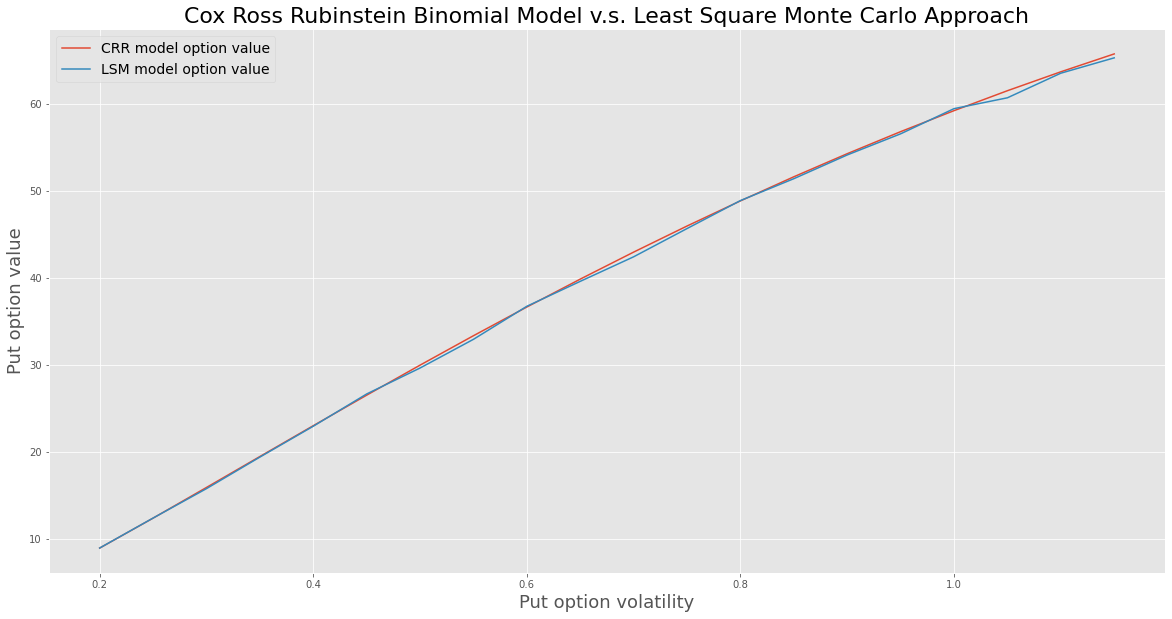

In [18]:
# comparison plot
plt.plot(sigma_list, CRR_binomial_model_value_volatility)
plt.plot(sigma_list, LSM_model_value_volatility)
plt.xlabel('Put option volatility', fontsize = 18)
plt.ylabel('Put option value', fontsize = 18)
plt.title('Cox Ross Rubinstein Binomial Model v.s. Least Square Monte Carlo Approach', fontsize = 22)
plt.legend(['CRR model option value','LSM model option value'], loc = "upper left", fontsize = 14)